## Geomorfometria no GRASS-GIS

### Comparação de MDEs Globais

#### jupyter-notebook por Carlos H. Grohmann (Guâno)

In [1]:
# imports
import sys, os, itertools
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
# import xarray as xr
import rioxarray as rxr

%matplotlib inline

In [2]:
# requires version 7.8+
# create GRASS GIS runtime environment

# definir o caminho do executável do GRASS, Aqui está para uma máquina Linux
# as duas formas abaixo retornam o mesmo resultado
gisbase = subprocess.check_output(["/usr/local/grass/bin/grass", "--config", "path"]).strip().decode() 
# gisbase = subprocess.check_output(["/usr/local/grass/bin/grass", "--config", "path"], text=True).strip() 

os.environ['GISBASE'] = gisbase
sys.path.append(os.path.join(gisbase, "etc", "python"))

# GRASS GIS imports
import grass.script as grass # este traz os módulos do GRASS
import grass.script.setup as gsetup
import grass.script.array as garray # este é para trabalhar com rasters como matrizes do numpy
# import grass.script.vector as gvect # este é para trablahar com vetores
import grass.jupyter as gj # este é para fazer o display dos mapas no notebook jupyter

# check GRASS version
print(gisbase)

/usr/local/grass/grass80


In [3]:
# set GRASS GIS session data

# aqui definimos o caminho da nossa Location/Mapset. Definir de acordo com o próprio sistema
rcfile = gsetup.init(gisbase, "/home/guano/HDD/grassdata/", "curso_yt", "yt")
# rcfile = gsetup.init(gisbase, "/mnt/d/grassdata/", "curso_yt", "yt")
# 
grass.message('Current GRASS GIS 7 environment:')
print (grass.gisenv())

{'GISDBASE': '/home/guano/HDD/grassdata/', 'LOCATION_NAME': 'curso_yt', 'MAPSET': 'yt'}


In [4]:
# define region - TODA A ÁREA DA CENA
n = -24
s = -25
w = -49
e = -48
res = '0:0:01'
grass.run_command('g.region', flags='pa', s=s, n=n, w=w, e=e, res=res)

In [5]:
# check region
grass.parse_command('g.region', flags='pg')

{'projection': '3',
 'zone': '0',
 'n': '-24',
 's': '-25',
 'w': '-49',
 'e': '-48',
 'nsres': '0.000277777777777778',
 'ewres': '0.000277777777777778',
 'rows': '3600',
 'cols': '3600',
 'cells': '12960000'}

In [6]:
# set data dir
datadir = '/home/guano/HDD/geodata/gdems/'
# datadir = "/mnt/d/geodata/srtm/"
# GDEMs
alaska   = f'{datadir}ALASKA_ASF-SRTM_AP_05776_FBS_F6690_RT1.dem.tif'
alos     = f'{datadir}ALOS_v3_ALPSMLC30_S025W049_DSM.tif'
aster    = f'{datadir}ASTGTMV003_S25W049_dem.tif'
cop_dted = f'{datadir}Copernicus_DSM_10_S25_00_W049_00_DEM.dt2'
cop_dged = f'{datadir}Copernicus_DSM_COG_10_S25_00_W049_00_DEM.tif'
nasa     = f'{datadir}s25w049.hgt'
srtm     = f'{datadir}S25W049.hgt'



### Importar GDEMs

In [7]:
# alaska srtm
grass.run_command('r.import', input=alaska, output='alaska', extent='input', overwrite=True)

In [8]:
# alos
grass.run_command('r.import', input=alos, output='alos', extent='input', overwrite=True)

In [9]:
# aster
grass.run_command('r.import', input=aster, output='aster', extent='input', overwrite=True)

In [10]:
# cop_dted
grass.run_command('r.import', input=cop_dted, output='cop_dted', extent='input', overwrite=True)

In [11]:
# cop_dged
grass.run_command('r.import', input=cop_dged, output='cop_dged', extent='input', overwrite=True)

In [12]:
# srtm
grass.run_command('r.in.srtm', input=srtm, output='srtm', flags='1', overwrite=True)

In [13]:
# nasadem
# g.extension extension=r.in.nasadem url=/home/guano/HDD/installs/grass-addons-master/grass7/raster/r.in.nasadem
grass.run_command('r.in.nasadem', output='nasa', local=datadir, overwrite=True)

In [14]:
# lista com os dems
dems = ['alaska','alos','aster','cop_dted','cop_dged','nasa','srtm']

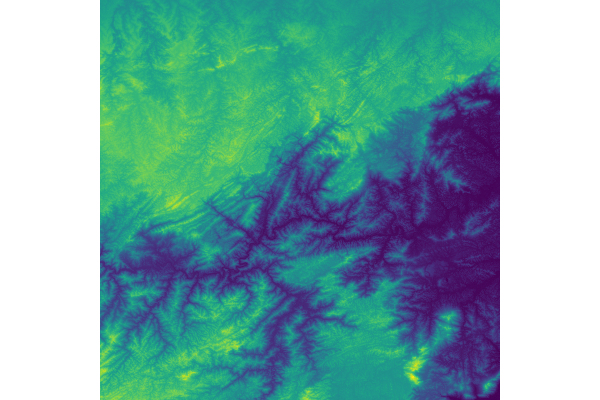

In [16]:
# Display map
img = gj.GrassRenderer()
img.run('d.rast', map='aster')
img.show()

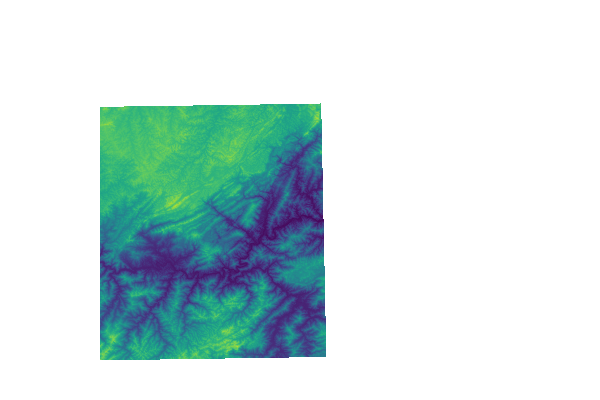

In [42]:
# Display map
img = gj.GrassRenderer()
img.run('d.rast', map='alaska')
img.show()

### metadados

In [17]:
grass.raster_info('srtm')

{'north': -23.9998611111111,
 'south': -25.0001388888889,
 'east': -47.9998611111111,
 'west': -49.0001388888889,
 'nsres': 0.000277777777777777,
 'ewres': 0.000277777777777779,
 'rows': '3601',
 'cols': '3601',
 'cells': '12967201',
 'datatype': 'CELL',
 'ncats': '0',
 'min': -50.0,
 'max': 1296.0,
 'map': 'srtm',
 'maptype': 'raster',
 'mapset': 'yt',
 'location': 'curso_yt',
 'database': '/home/guano/HDD/grassdata/',
 'date': '"Mon Dec  6 11:43:03 2021"',
 'creator': '"guano"',
 'title': '""',
 'timestamp': '"none"',
 'units': '"none"',
 'vdatum': '"none"',
 'source1': '""',
 'source2': '""',
 'description': '"generated by r.in.gdal"',
 'comments': '"r.in.gdal input="S25W049.bil" output="srtm" memory=300 offset=0 num_\\digits=0r.in.srtm --o -1 input=/home/guano/HDD/geodata/gdems/S25W049.hgt output=srtm"'}

In [22]:
n = '24:19S'
s = '24:52S'
w = '48:57W'
e = '48:30W'
res = '0:0:01'
grass.run_command('g.region', flags='a', s=s, n=n, w=w, e=e, res=res, save='compara', overwrite=True)

In [25]:
dem = 'srtm'
grass.parse_command('r.univar', map=dem, flags='g')

{'n': '3207600',
 'null_cells': '0',
 'cells': '3207600',
 'min': '24',
 'max': '1206',
 'range': '1182',
 'mean': '612.140673088914',
 'mean_of_abs': '612.140673088914',
 'stddev': '277.102149674636',
 'variance': '76785.6013543044',
 'coeff_var': '45.2677238838509',
 'sum': '1963502423'}

In [44]:
# get stats for each dem and put all in a dataframe
cols = ['dem','min','max','mean','stddev']
all_stats = []

for dem in dems:
    univar = grass.parse_command('r.univar', map=dem, flags='g')
    rmin = float(univar['min'])
    rmax = float(univar['max'])
    ravg = float(univar['mean'])
    rstd = float(univar['stddev'])
    all_stats.append([dem,rmin,rmax,ravg,rstd])


In [45]:
pd_stats = pd.DataFrame(all_stats,columns=cols)
pd_stats.set_index('dem')

min          max        mean      stddev
dem                                                
alaska    28.0  1206.000000  611.870147  277.145023
alos      27.0  1215.000000  614.106365  276.774878
aster     26.0  1208.000000  608.220255  277.601420
cop_dted  51.0  1215.000000  611.173719  277.158137
cop_dged  51.0  1214.989014  611.186951  277.178117
nasa      30.0  1200.000000  609.821895  277.012245
srtm      24.0  1206.000000  612.140673  277.102150

### Mapa hipsométrico

In [53]:
# regra de reclassificação
hipso_class = '''-50 thru 100 = 1 0 - 100m
100 thru 200 = 2 100 - 200m
200 thru 300 = 3 200 - 300m
300 thru 400 = 4 300 - 400m
400 thru 500 = 5 400 - 500m
500 thru 600 = 6 500 - 600m
600 thru 700 = 7 600 - 700m
700 thru 800 = 8 700 - 800m
800 thru 900 = 9 800 - 900m
900 thru 1000 = 10 900 - 1000m
1000 thru 1500 = 11 1000 - 1500m'''

In [57]:
grass.write_command('r.reclass', input='nasa', output='nasa_hipso', rules='-', stdin=hipso_class, overwrite=True);

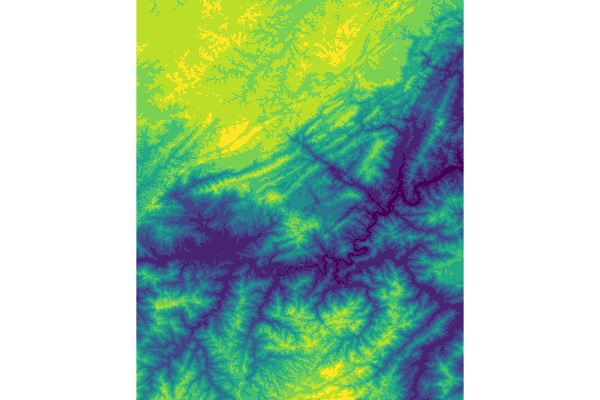

In [58]:
# Display map
img = gj.GrassRenderer()
img.run('d.rast', map='nasa_hipso') 
img.show()

### Relevo sombreado, declividade e aspecto

In [46]:
# make shaded reliefs
def make_shaded(raster, az, alt):
    out_shade = f'{raster}_shade_{az:03}_{alt}'
    grass.run_command('r.relief', input=raster, output=out_shade, altitude=alt, azimuth=az, overwrite=True)

In [47]:
# shaded illumination azimuth: 45deg
for d in dems:
    print(f'calculating shaded relief of {d}...')
    az = 45
    alt = 30
    make_shaded(d,az,alt)

calculating shaded relief of alaska...
calculating shaded relief of alos...
calculating shaded relief of aster...
calculating shaded relief of cop_dted...
calculating shaded relief of cop_dged...
calculating shaded relief of nasa...
calculating shaded relief of srtm...


In [48]:
# shaded illumination azimuth: 315deg
for d in dems:
    print(f'calculating shaded relief of {d}...')
    az = 315
    alt = 30
    make_shaded(d,az,alt)

calculating shaded relief of alaska...
calculating shaded relief of alos...
calculating shaded relief of aster...
calculating shaded relief of cop_dted...
calculating shaded relief of cop_dged...
calculating shaded relief of nasa...
calculating shaded relief of srtm...


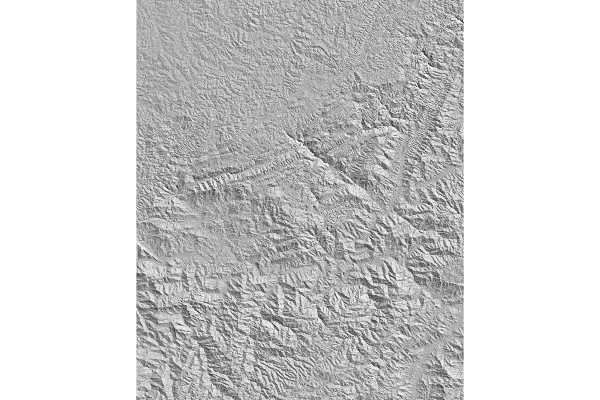

In [49]:
# Display map
img = gj.GrassRenderer()
img.run('d.rast', map='srtm_shade_045_30') # raster simples, pode ter essa linha mais de uma vez
img.show()

In [ ]:
# conferir mudança nos mapas de relevo sombreado com iluminações diferentes na GUI

In [50]:
# slope and aspect
for d in dems:
    print(f'calculating slope and aspect of {d}...')
    out_slope = f'{d}_slope'
    out_aspect = f'{d}_aspect'
    grass.run_command('r.slope.aspect', elevation=d, slope=out_slope, aspect=out_aspect, overwrite=True)

calculating slope and aspect of alaska...
calculating slope and aspect of alos...
calculating slope and aspect of aster...
calculating slope and aspect of cop_dted...
calculating slope and aspect of cop_dged...
calculating slope and aspect of nasa...
calculating slope and aspect of srtm...


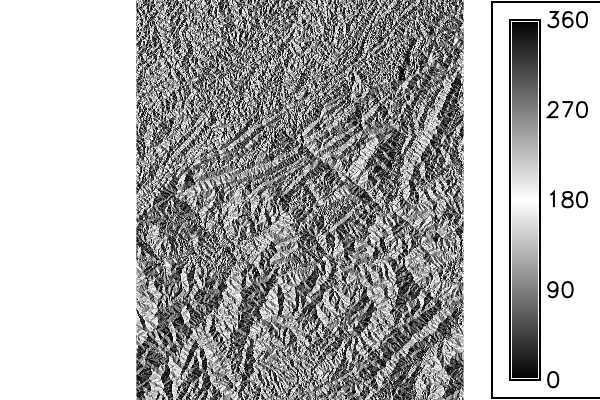

In [63]:
# Display map
img = gj.GrassRenderer()
img.run('d.rast', map='srtm_aspect')
img.run('d.legend',raster='srtm_aspect', at=(5, 95, 85, 90), flags="b")
img.show()

In [65]:
# corrigir valores de aspect para orientação geográfica
r_in = 'srtm_aspect'
r_out = 'srtm_aspect_compass'
grass.mapcalc(f'{r_out} = if({r_in}<=90, 90-{r_in}, 360+90-{r_in})', overwrite=True)

In [ ]:
grass.run_command('r.colors', map=r_out, color='aspect', overwrite=True)

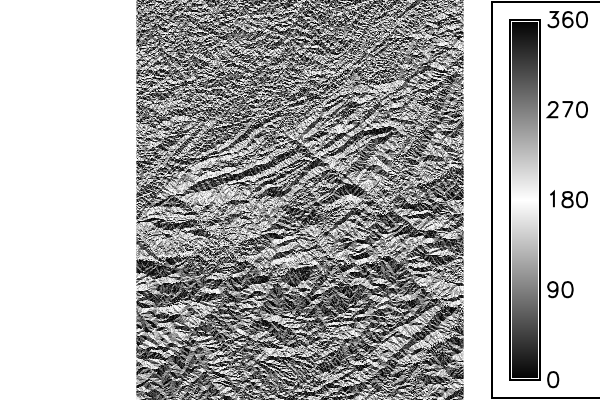

In [66]:
# Display map
img = gj.GrassRenderer()
img.run('d.rast', map='srtm_aspect_compass')
img.run('d.legend',raster='srtm_aspect_compass', at=(5, 95, 85, 90), flags="b")
img.show()

In [67]:
# arrumar cores para aspect_compass
asp_col_bw = '''0 white
180 black
360 white'''

grass.write_command('r.colors', map='srtm_aspect_compass', rules='-', stdin=asp_col_bw, overwrite=True);

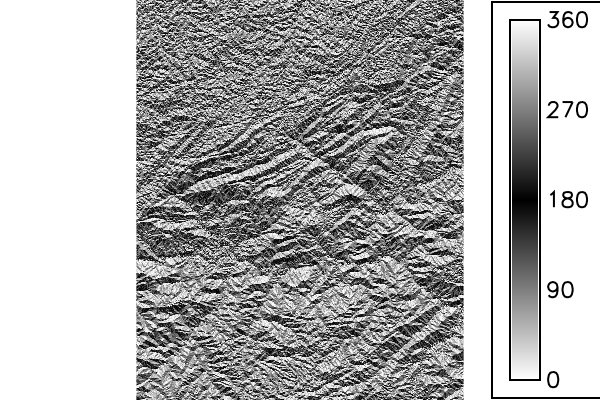

In [68]:
# Display map
img = gj.GrassRenderer()
img.run('d.rast', map='srtm_aspect_compass')
img.run('d.legend',raster='srtm_aspect_compass', at=(5, 95, 85, 90), flags="b")
img.show()

### artefatos do aspecto

In [ ]:
# teste de tempo - função própria ou xarray

In [26]:
%%timeit

# função para trazer o raster do GRASS como matriz (vetor)
def raster_as_array(raster):
    ''' return GRASS raster as numpy array'''
    raster_array = garray.array()
    raster_array.read(raster, null=np.nan)
    raster_array_flat = raster_array.flatten(order='C')
    return raster_array_flat

asp_comp_arr = raster_as_array('srtm_aspect_compass')

779 ms ± 36.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
%%timeit

rast_in = 'srtm_aspect_compass'
rast_out = f'{datadir}srtm_aspect_compass.tif'
# export
grass.run_command('r.out.gdal', input=rast_in, output=rast_out, format='GTiff', overwrite=True)
# read with xarray
asp_comp_xr = rxr.open_rasterio(rast_out)
asp_comp_xr_series = asp_comp_xr.to_series() #.dropna()

260 ms ± 5.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
rast_in = 'srtm_aspect_compass'
rast_out = f'{datadir}srtm_aspect_compass.tif'

grass.run_command('r.out.gdal', input=rast_in, output=rast_out, format='GTiff', overwrite=True)

In [28]:
asp_comp_xr = rxr.open_rasterio(rast_out)
asp_comp_xr_series = asp_comp_xr.to_series() #.dropna()

In [29]:
asp_comp_xr_series

band  y           x         
1     -24.316806  -48.949861   NaN
                  -48.949583   NaN
                  -48.949306   NaN
                  -48.949028   NaN
                  -48.948750   NaN
                                ..
      -24.866528  -48.501250   NaN
                  -48.500972   NaN
                  -48.500694   NaN
                  -48.500417   NaN
                  -48.500139   NaN
Length: 3207600, dtype: float32

In [31]:
asp_pd = pd.DataFrame()
asp_pd['srtm'] = asp_comp_xr_series.dropna()

In [32]:
asp_pd

srtm
band y          x                     
1    -24.317083 -48.949861  334.935547
                -48.949583  270.000000
                -48.949306  247.386475
                -48.949028  239.751328
                -48.948750  206.382431
...                                ...
     -24.866250 -48.501528  125.262268
                -48.501250  127.743225
                -48.500972  132.374969
                -48.500694  141.746918
                -48.500417  153.889282

[3202382 rows x 1 columns]

<AxesSubplot:>

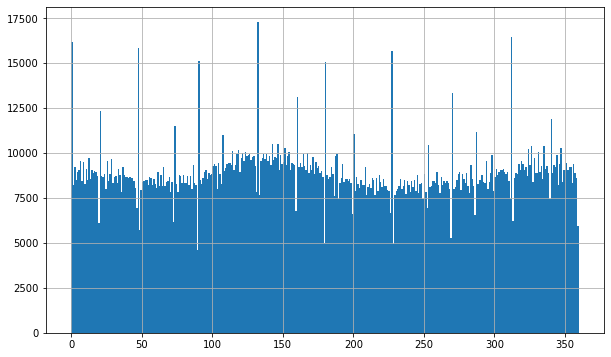

In [91]:
asp_pd['srtm'].hist(bins=360, figsize=(10,6))

In [ ]:
# reamostragem do srtm para float

In [97]:
res = '0:0:00.9'
grass.run_command('g.region', flags='pam', s=s, n=n, w=w, e=e, res=res)

In [98]:
grass.run_command('r.resamp.interp', input='srtm', output='srtm_float', method='bilinear', overwrite=True)

In [99]:
r = 'srtm_float'
r_slope = 'srtm_float_slope'
r_aspect = 'srtm_float_aspect'
grass.run_command('r.slope.aspect', elevation=r, slope=r_slope, aspect=r_aspect, overwrite=True)

In [100]:
r_in = 'srtm_float_aspect'
r_out = 'srtm_float_aspect_compass'
grass.mapcalc(f'{r_out} = if({r_in}<=90, 90-{r_in}, 360+90-{r_in})', overwrite=True)

In [33]:
rast_in = 'srtm_float_aspect_compass'
rast_out = f'{datadir}srtm_float_aspect_compass.tif'

grass.run_command('r.out.gdal', input=rast_in, output=rast_out, format='GTiff', overwrite=True)

In [34]:
asp_comp_xr = rxr.open_rasterio(rast_out)
asp_comp_xr_series = asp_comp_xr.to_series() #.dropna()

In [35]:
asp_pd = pd.DataFrame()
asp_pd['srtm'] = asp_comp_xr_series.dropna()

<AxesSubplot:>

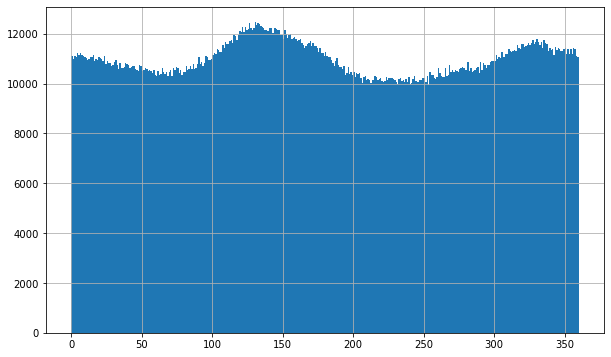

In [104]:
asp_pd['srtm'].hist(bins=360, figsize=(10,6))

## Comparações entre os GDEMs

### perfis topográficos

In [36]:
# perfis 
coords=(-48.705655893536125, -24.488149889733844, -48.653374524714835, -24.686819091254755)

dems = ['alaska','alos','aster','cop_dted','cop_dged','nasa','srtm']

# lists for creation of long-format dataframe
x = []
y = []
gdem = []

for dem in dems:
    profile = grass.read_command('r.profile', input=dem , output='-', coordinates=coords, null='*')
    p_x = profile.split()[0::2]
    p_y = profile.split()[1::2]
    x.append([float(num) for num in p_x])
    y.append([float(num) for num in p_y])
    gdem.append([dem]*len(p_x))

x_long = np.concatenate(x)
y_long = np.concatenate(y)
d_long = np.concatenate(gdem)

In [37]:
# cria dataframe com os dados dos perfis
df_profile = pd.DataFrame(list(zip(d_long,x_long,y_long)),columns=['gdem','x','y'])

In [38]:
df_profile

gdem             x      y
0     alaska      0.000000  823.0
1     alaska     30.605760  838.0
2     alaska     61.211520  854.0
3     alaska     91.817281  864.0
4     alaska    122.423041  882.0
...      ...           ...    ...
5175    srtm  22494.551420  270.0
5176    srtm  22525.155364  258.0
5177    srtm  22555.759308  249.0
5178    srtm  22586.363252  245.0
5179    srtm  22616.967196  235.0

[5180 rows x 3 columns]

<AxesSubplot:xlabel='x', ylabel='y'>

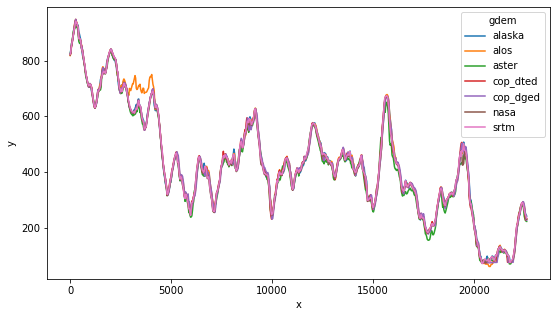

In [192]:
# plot com seaborn
# https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot
plt.figure(figsize=(9,5))
sns.lineplot(data=df_profile,x="x", y="y", hue="gdem")

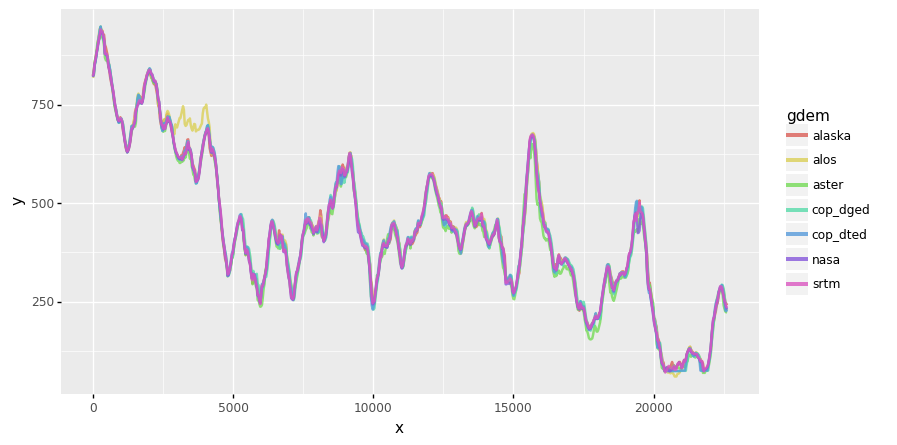

In [193]:
# plot com plotnine
# https://plotnine.readthedocs.io/en/stable/generated/plotnine.geoms.geom_line.html#plotnine.geoms.geom_line
(p9.ggplot(df_profile)
+p9.geom_line(mapping=p9.aes(x='x', color='gdem',
                y='y'), position='position_identity',
                alpha=0.8, size=1)
# +p9.scales.xlim(0,200)
# +p9.scales.ylim(0,3.5)
# +p9.xlab(f'Slope (percent)')
# +p9.ylab(f'Percent of total')
# +p9.ggtitle(f'Slope - Histograms (bin={binw}%) - LatLong')
# +p9.annotate('text', x=65, y=2.8, size=10, ha='left', label='IF')
+p9.theme(figure_size=(9,5))#,legend_position=(0.75,0.7))
).draw();

### estatísticas e gráficos

In [39]:
# set region
grass.run_command('g.region', flags='pa', region='compara')

In [136]:
# vamos trazer todos os rasters como arrays

In [40]:
# lista dos dems
dems = ['alaska','alos','aster','cop_dted','cop_dged','nasa','srtm']

In [41]:
# export as geotiff
for dem in dems:
    rast_in = dem
    rast_out = f'{datadir}{dem}.tif'
    grass.run_command('r.out.gdal', input=rast_in, output=rast_out, format='GTiff', flags='cm', overwrite=True)    

In [43]:
# open as array and add to dataframe
gdems_df = pd.DataFrame()

for dem in dems:
    rast_out = f'{datadir}{dem}.tif'
    dem_xr = rxr.open_rasterio(rast_out)
    dem_xr_series = dem_xr.to_series() #.dropna()
    gdems_df[dem] = dem_xr_series

In [44]:
gdems_df

alaska  alos  aster  cop_dted    cop_dged  nasa  \
band y          x                                                             
1    -24.316806 -48.949861     905   903    899       903  903.119568   903   
                -48.949583     906   904    900       904  904.302429   904   
                -48.949306     908   905    902       904  904.306824   905   
                -48.949028     909   906    904       905  904.596985   907   
                -48.948750     910   908    902       906  906.388611   908   
...                            ...   ...    ...       ...         ...   ...   
     -24.866528 -48.501250     535   533    524       532  546.869202   531   
                -48.500972     521   518    511       514  528.890564   516   
                -48.500694     498   504    488       494  513.850830   502   
                -48.500417     493   493    482       485  500.172150   488   
                -48.500139     482   486    476       481  497.298096   481   

                            srtm  
band y          x                 
1    -24.316806 -48.949861   905  
                -48.949583   905  
                -48.949306   907  
                -48.949028   909  
                -48.948750   910  
...                          ...  
     -24.866528 -48.501250   538  
                -48.500972   518  
                -48.500694   504  
                -48.500417   490  
                -48.500139   481  

[3207600 rows x 7 columns]

In [46]:
gdems_df.describe().transpose()

count        mean         std   min         25%         50%  \
alaska    3207600.0  611.870147  277.145066  28.0  364.000000  642.000000   
alos      3207600.0  614.106365  276.774921  27.0  366.000000  649.000000   
aster     3207600.0  608.220255  277.601464  26.0  360.000000  639.000000   
cop_dted  3207600.0  611.173719  277.158180  51.0  363.000000  642.000000   
cop_dged  3207600.0  611.186768  276.858063  51.0  363.424355  641.990417   
nasa      3207600.0  609.821895  277.012288  30.0  362.000000  640.000000   
srtm      3207600.0  612.140673  277.102193  24.0  364.000000  642.000000   

                 75%          max  
alaska    877.000000  1206.000000  
alos      876.000000  1215.000000  
aster     874.000000  1208.000000  
cop_dted  875.000000  1215.000000  
cop_dged  875.430557  1214.989014  
nasa      875.000000  1200.000000  
srtm      877.000000  1206.000000

In [51]:
# convert to long-format
gdems_long = gdems_df.reset_index().drop(columns=['band','x','y']).melt()

In [146]:
gdems_long

variable  value
0          alaska  905.0
1          alaska  906.0
2          alaska  908.0
3          alaska  909.0
4          alaska  910.0
...           ...    ...
22453195     srtm  538.0
22453196     srtm  518.0
22453197     srtm  504.0
22453198     srtm  490.0
22453199     srtm  481.0

[22453200 rows x 2 columns]

<AxesSubplot:xlabel='variable', ylabel='value'>

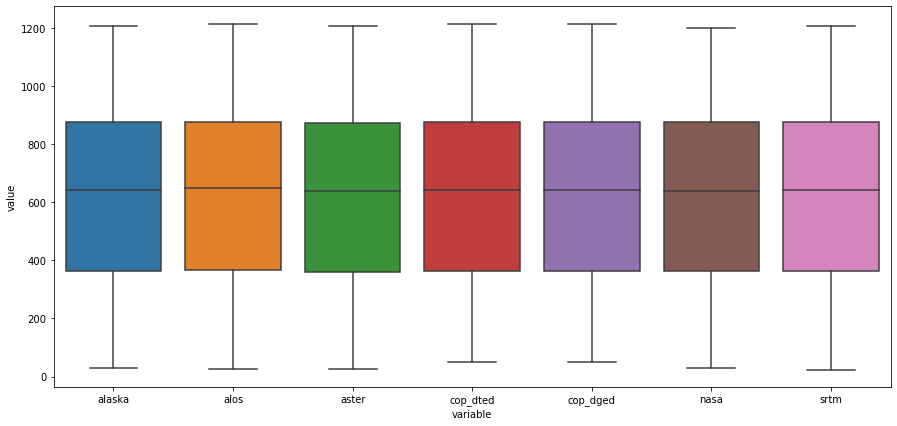

In [52]:
# boxplot
plt.figure(figsize=(15,7))
sns.boxplot(x='variable', y='value', data=gdems_long, fliersize=1)

<AxesSubplot:xlabel='variable', ylabel='value'>

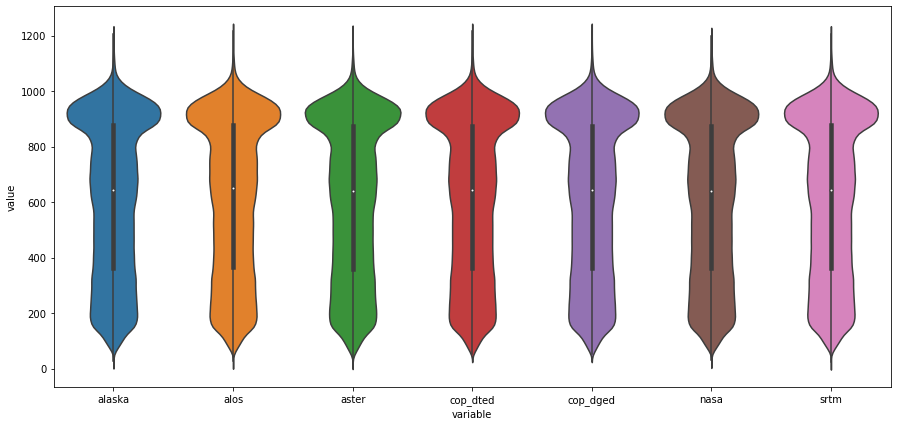

In [150]:
# violinplot
plt.figure(figsize=(15,7))
sns.violinplot(x='variable', y='value', data=gdems_long)

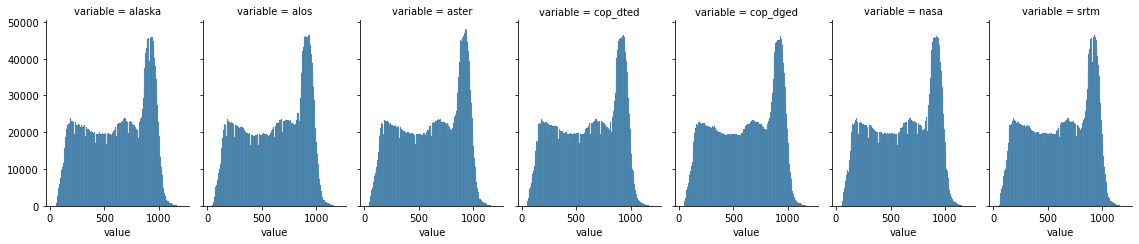

In [151]:
# plt.figure(figsize=(10,6))
g = sns.FacetGrid(gdems_long, col='variable', height=3.5, aspect=.65)
g.map(sns.histplot, 'value')

### gráficos de correlação - elevação

In [152]:
x_line = [0,1200]
y_line = [0,1200]

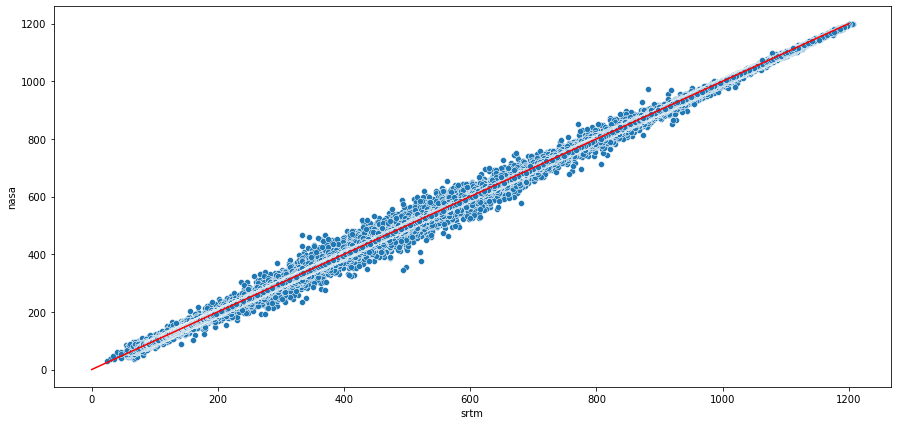

In [153]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=gdems_df, x='srtm', y='nasa')
plt.plot(x_line, y_line, color='r')

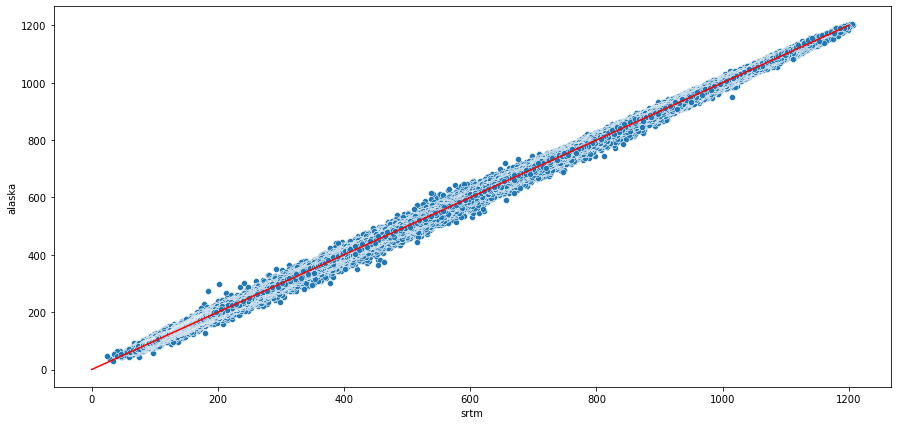

In [154]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=gdems_df, x='srtm', y='alaska')
plt.plot(x_line, y_line, color='r')

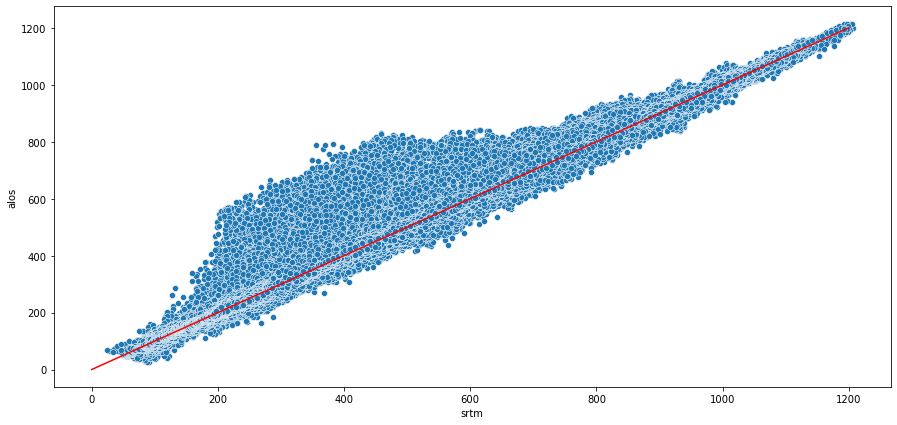

In [155]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=gdems_df, x='srtm', y='alos')
plt.plot(x_line, y_line, color='r')

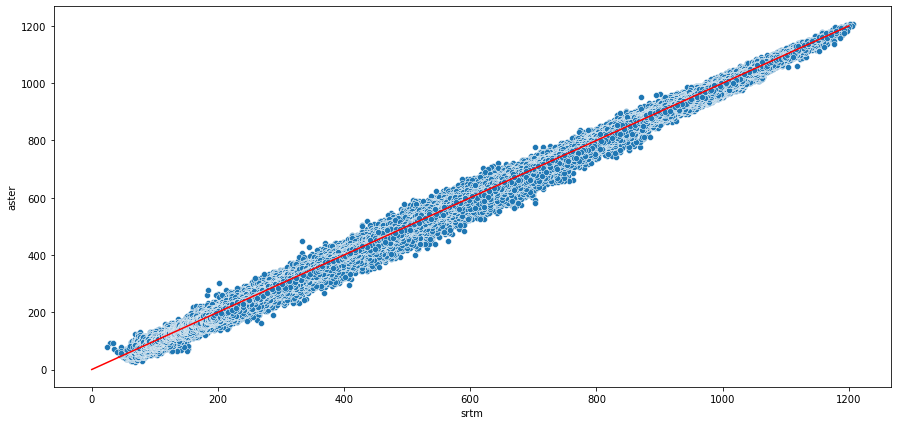

In [156]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=gdems_df, x='srtm', y='aster')
plt.plot(x_line, y_line, color='r')

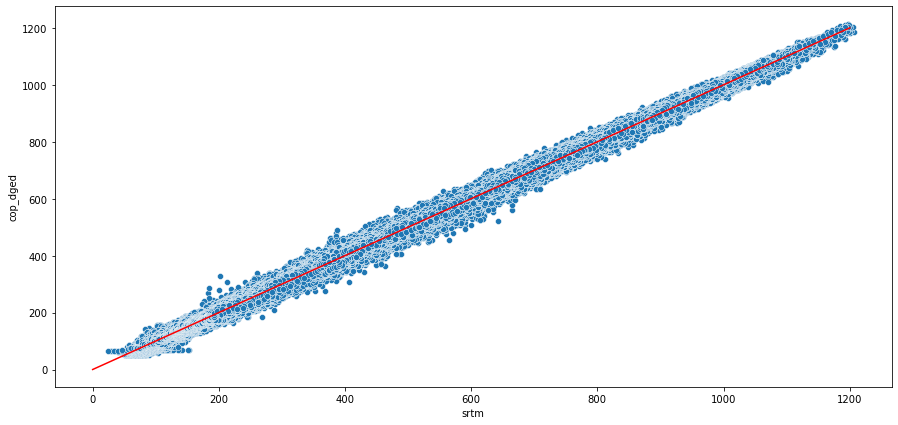

In [157]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=gdems_df, x='srtm', y='cop_dged')
plt.plot(x_line, y_line, color='r')

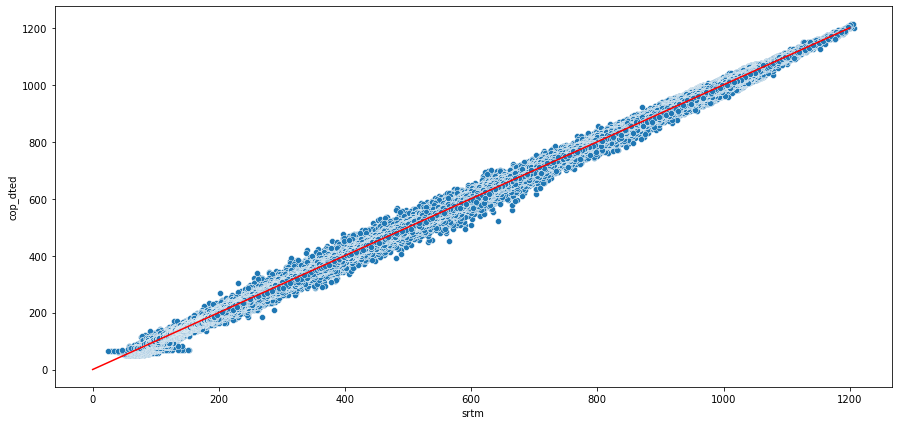

In [158]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=gdems_df, x='srtm', y='cop_dted')
plt.plot(x_line, y_line, color='r')

### gráficos de correlação - slope

In [159]:
dems = ['alos','cop_dted','cop_dged','srtm']

In [160]:
# export as geotiff
for dem in dems:
    rast_in = f'{dem}_slope'
    rast_out = f'{datadir}{dem}_slope.tif'
    grass.run_command('r.out.gdal', input=rast_in, output=rast_out, format='GTiff', flags='cm', overwrite=True)    

In [164]:
# open as array and add to dataframe
gdems_df = pd.DataFrame()

for dem in dems:
    rast_out = f'{datadir}{dem}_slope.tif'
    dem_xr = rxr.open_rasterio(rast_out)
    dem_xr_series = dem_xr.to_series() #.dropna()
    gdems_df[f'{dem}_slope'] = dem_xr_series

In [167]:
x_lslope = [0,90]
y_lslope = [0,90]

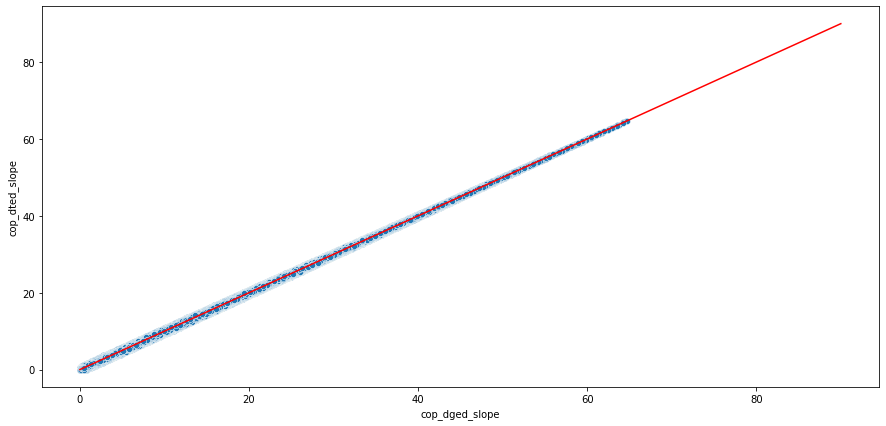

In [168]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=gdems_df, x='cop_dged_slope', y='cop_dted_slope')
plt.plot(x_lslope, y_lslope, color='r')

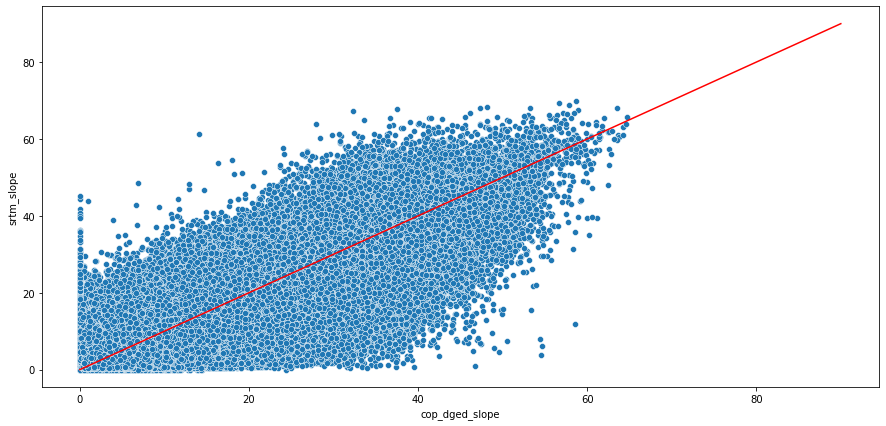

In [169]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=gdems_df, x='cop_dged_slope', y='srtm_slope')
plt.plot(x_lslope, y_lslope, color='r')

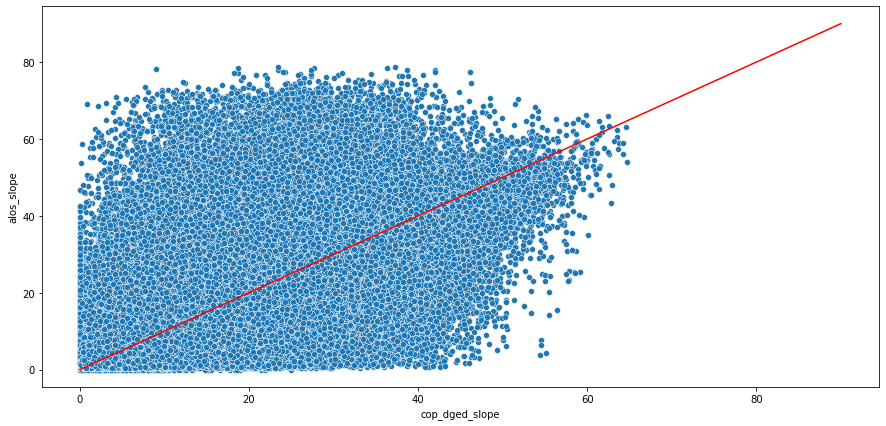

In [170]:
plt.figure(figsize=(15,7))
sns.scatterplot(data=gdems_df, x='cop_dged_slope', y='alos_slope')
plt.plot(x_lslope, y_lslope, color='r')

### mapas de diferenças

In [180]:
# DoD COP menos SRTM
r1 = 'srtm'
r2 = 'cop_dged'
r_out = 'cop_minus_srtm'
grass.mapcalc(f'{r_out} = {r2}-{r1}', overwrite=True)

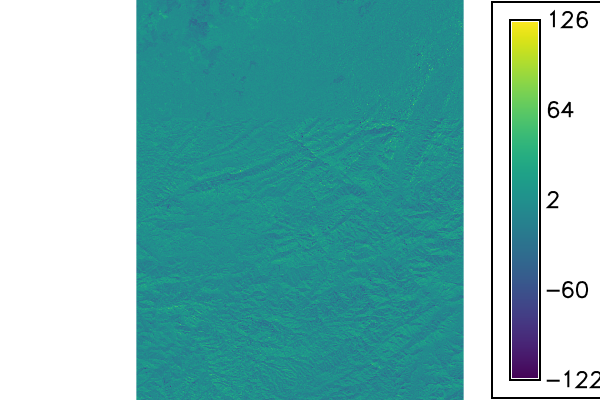

In [181]:
# Display map
img = gj.GrassRenderer()
img.run('d.rast', map=r_out)
img.run('d.legend',raster=r_out, at=(5, 95, 85, 90), flags="b")
img.show()

In [183]:
grass.run_command('r.colors', map=r_out, color='differences', overwrite=True);

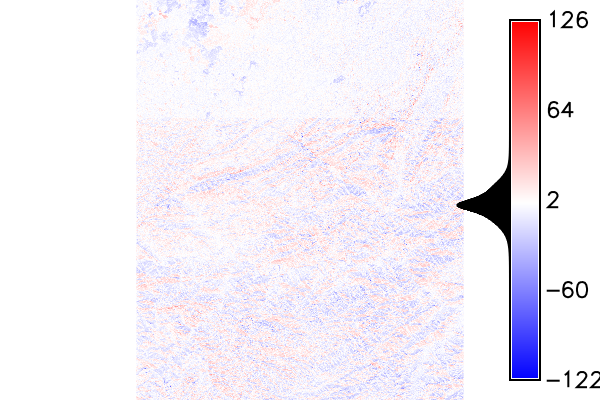

In [185]:
# Display map
img = gj.GrassRenderer()
img.run('d.rast', map=r_out)
img.run('d.legend',raster=r_out, at=(5, 95, 85, 90), flags="d")
img.show()

In [188]:
# COP menos ALOS
r1 = 'alos'
r2 = 'cop_dged'
r_out = 'cop_minus_alos'
grass.mapcalc(f'{r_out} = {r2}-{r1}', overwrite=True)

In [189]:
grass.run_command('r.colors', map=r_out, color='differences', overwrite=True);

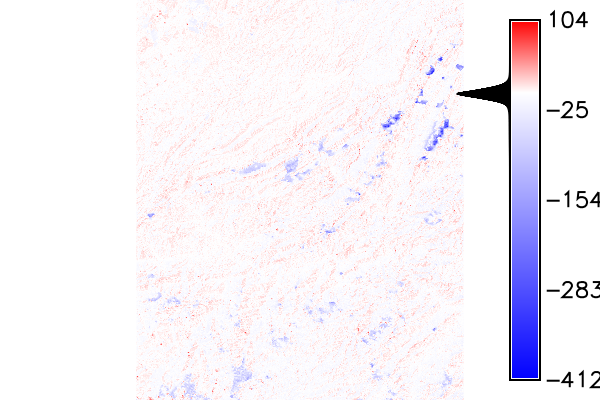

In [191]:
# Display map
img = gj.GrassRenderer()
img.run('d.rast', map=r_out)
img.run('d.legend',raster=r_out, at=(5, 95, 85, 90), flags="d")
img.show()